In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


import sys
sys.path.append('../')
from utils import *

In [2]:
is_kaggle = False

if is_kaggle:
    base_dir = '/kaggle/input'
    data_dir = f'{base_dir}/linking-writing-processes-to-writing-quality'
    output_dir = '/kaggle/working'
else:
    base_dir = '../'
    data_dir = f'{base_dir}/data'
    models_dir = f'{base_dir}/models'

In [3]:
train_logs_df = pd.read_csv(f'{data_dir}/train_logs.csv')
train_scores_df = pd.read_csv(f'{data_dir}/train_scores.csv')

test_logs_df = pd.read_csv(f'{data_dir}/test_logs.csv')

In [4]:
essayConstructor = EssayConstructor()
train_essays = essayConstructor.getEssays(train_logs_df)

100%|██████████| 2471/2471 [00:06<00:00, 389.36it/s]


In [5]:
train_essays.index = train_essays["id"]
train_essays.index.name = None
train_essays.drop(columns=["id"], inplace=True)
train_essays.head()

,essay
001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


In [6]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)

In [7]:
# Paragraph features for train dataset
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [8]:
test_essays = essayConstructor.getEssays(test_logs_df)
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

100%|██████████| 3/3 [00:00<00:00, 3302.60it/s]


In [9]:
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs_df)
test_feats = preprocessor.make_feats(test_logs_df)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [01:45<00:00,  3.18s/it, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 12447.78it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 11879.91it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 11183.58it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 11182.20it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 11628.23it/s]


Engineering input words data


c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:365: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:367: PerformanceWarning: DataFrame is highly fragmented.  This 

Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [00:01<00:00, 26.13it/s, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 2971.87it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<00:00, 2964.87it/s]

Engineering input words data
Engineering ratios data



c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:365: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:367: PerformanceWarning: DataFrame is highly fragmented.  This

In [10]:
train_agg_fe_df = train_logs_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

test_agg_fe_df = test_logs_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [11]:
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs_df, test_logs_df]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores_df, on='id', how='left')

In [12]:
# Adding the additional features to the original feature set

train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')
# test_feats = test_feats.merge(test_sent_agg_df, on='id', how='left')
# test_feats = test_feats.merge(test_paragraph_agg_df, on='id', how='left')

## Copy from keyboard notebook

In [13]:
def get_keyboard_mouse_feats(train_logs_df):

    # Creates two shift variables which lag the original variable by 1 and 2 periods respectively.
    event_df = train_logs_df[['id', 'event_id', 'down_event']].copy(deep=True)

    event_df['down_event_shift_1'] = event_df['down_event'].shift(periods=1)
    event_df['down_event_shift_2'] = event_df['down_event'].shift(periods=2)

    event_df = event_df[['id', 'event_id', 'down_event_shift_2', 'down_event_shift_1', 'down_event']]

    ctrl_left_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'ArrowLeft')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_right_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'ArrowRight')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_shift_left_df = ((event_df['down_event_shift_2'] == 'Control') & (event_df['down_event_shift_1'] == 'Shift') & (event_df['down_event'] == 'ArrowLeft')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_shift_right_df = ((event_df['down_event_shift_2'] == 'Control') & (event_df['down_event_shift_1'] == 'Shift') & (event_df['down_event'] == 'ArrowRight')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_bksp_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'Backspace')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_c_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'c')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_v_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'v')).groupby(event_df['id']).sum().reset_index(name='count')
    ctrl_x_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'x')).groupby(event_df['id']).sum().reset_index(name='count')

    # Creating a DataFrame that contains all counts at an id level.

    kb_shortcut_df = pd.DataFrame(event_df['id'].unique(), columns=['id'])

    kb_shortcut_df['ctrl_left_cnt'] = ctrl_left_df['count']
    kb_shortcut_df['ctrl_right_cnt'] = ctrl_right_df['count']
    kb_shortcut_df['ctrl_shift_left_cnt'] = ctrl_shift_left_df['count']
    kb_shortcut_df['ctrl_shift_right_cnt'] = ctrl_shift_right_df['count']
    kb_shortcut_df['ctrl_bksp_cnt'] = ctrl_bksp_df['count']
    kb_shortcut_df['ctrl_c_cnt'] = ctrl_c_df['count']
    kb_shortcut_df['ctrl_v_cnt'] = ctrl_v_df['count']
    kb_shortcut_df['ctrl_x_cnt'] = ctrl_x_df['count']

    mouse_event_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])

    # Calculating the proportion of mouse click events
    mouse_event_df['mouse_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['down_event'].apply(lambda x: (x.isin(['Leftclick', 'Rightclick', 'Middleclick', 'Unknownclick']).sum())).reset_index()['down_event']

    mouse_event_df['all_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['event_id'].max().reset_index()['event_id']

    mouse_event_df['mouse_event_perc'] = (mouse_event_df['mouse_event_cnt']/mouse_event_df['all_event_cnt'])*100.0

    # Combining both sets of features into one DataFrame
    kb_features = ['ctrl_left_cnt', 'ctrl_right_cnt', 'ctrl_shift_left_cnt', 'ctrl_shift_right_cnt', 'ctrl_bksp_cnt', 
                'ctrl_c_cnt', 'ctrl_v_cnt', 'ctrl_x_cnt']

    ms_features = ['mouse_event_perc']

    ms_kb_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])

    for col in kb_features:
        ms_kb_df[col] = kb_shortcut_df[col]

    for col in ms_features:
        ms_kb_df[col] = mouse_event_df[col]
    
    return ms_kb_df

In [14]:
ms_kb_df = get_keyboard_mouse_feats(train_logs_df)
train_feats = train_feats.merge(ms_kb_df, on='id', how='left')

## Training

In [15]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [26]:
train_feats.fillna(-999, inplace=True)
train_feats.replace([np.inf, -np.inf], -999, inplace=True)

In [32]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15, random_state=42)

    params = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.5,0.6,0.7,0.8,0.9]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.5,0.6,0.7,0.8,0.9]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4,0.5,0.6,0.7,0.8,0.9]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5,0.6,0.7,0.8,0.9]),
        'eta': trial.suggest_float('learning_rate', 1e-6, 5e-2, log=True),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000, 1500, 2000, 2500, 3000]),
        'max_depth': trial.suggest_int('max_depth', 3, 9, step=1),
    }

    all_params = {
        'tree_method':'gpu_hist',
        'objective': 'reg:squarederror',
        'eval_metric': ['rmse'],
        'seed': 42,
        'nthread': -1,
        'early_stopping_rounds': 50,
        **params
    }


    model = xgb.XGBRegressor(**all_params)
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [33]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-03 18:27:29,572] A new study created in memory with name: no-name-64d72b8d-1a53-4f4c-987e-2bdd0e269555


[I 2023-12-03 18:27:50,119] Trial 0 finished with value: 0.7828850086933009 and parameters: {'lambda': 3.4968363036719508, 'alpha': 2.2352993909736862, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.0009674918059148546, 'n_estimators': 2000, 'max_depth': 5}. Best is trial 0 with value: 0.7828850086933009.
[I 2023-12-03 18:27:51,598] Trial 1 finished with value: 0.5786958872495837 and parameters: {'lambda': 0.19471386189297338, 'alpha': 0.007680570454164113, 'colsample_bytree': 0.4, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.4, 'subsample': 0.4, 'learning_rate': 0.042442109366465045, 'n_estimators': 3000, 'max_depth': 5}. Best is trial 1 with value: 0.5786958872495837.
[I 2023-12-03 18:28:12,034] Trial 2 finished with value: 3.3450607405094015 and parameters: {'lambda': 0.029873143771947407, 'alpha': 3.502337093904659, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'subsample': 0.7, 'lear

Number of finished trials: 50
Best trial: {'lambda': 0.8478693470969416, 'alpha': 0.008209636821029959, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.01111345503114425, 'n_estimators': 2500, 'max_depth': 3}


In [35]:
study.trials_dataframe().sort_values(by='value', ascending=True).head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bylevel,params_colsample_bynode,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,state
43,43,0.565716,2023-12-03 18:35:07.382519,2023-12-03 18:35:11.116799,0 days 00:00:03.734280,0.008210,0.8,0.6,0.7,0.847869,0.011113,3,2500,0.4,COMPLETE
44,44,0.567641,2023-12-03 18:35:11.117799,2023-12-03 18:35:13.983713,0 days 00:00:02.865914,0.012077,0.8,0.6,0.7,1.117005,0.012378,3,2500,0.5,COMPLETE
48,48,0.568373,2023-12-03 18:35:21.055585,2023-12-03 18:35:24.311438,0 days 00:00:03.255853,0.007574,0.8,0.8,0.7,0.335249,0.014696,4,2500,0.5,COMPLETE
10,10,0.569107,2023-12-03 18:30:51.229128,2023-12-03 18:30:52.515835,0 days 00:00:01.286707,0.001618,0.5,0.7,0.8,0.182090,0.042383,4,3000,0.4,COMPLETE
31,31,0.569438,2023-12-03 18:34:09.656816,2023-12-03 18:34:13.366143,0 days 00:00:03.709327,0.005063,0.9,0.5,0.9,0.753512,0.007619,3,3000,0.4,COMPLETE


## Use best params

In [37]:
best_trial = study.best_trial.params
print(best_trial)

{'lambda': 0.8478693470969416, 'alpha': 0.008209636821029959, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.01111345503114425, 'n_estimators': 2500, 'max_depth': 3}


In [38]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

In [42]:
models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_logs_df['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        best_params = {
            'tree_method':'hist',
            'objective': 'reg:squarederror',
            'eval_metric': ['rmse'],
            'seed': 42,
            'nthread': -1,
            'early_stopping_rounds': 50,
            **best_trial
        }
        
        model = xgb.XGBRegressor(**best_params)
        
        model.fit(X_train,y_train, eval_set=[(X_valid,y_valid)], verbose=False)

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [43]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))

In [45]:
print('OOF metric XGB = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric XGB = 0.61118


In [46]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [47]:
import math
def round_to_half(numbers, round_up=False):
    if round_up:
        return [round(num * 2) / 2 for num in numbers]
    else:
        return [math.floor(num * 2) / 2 for num in numbers]

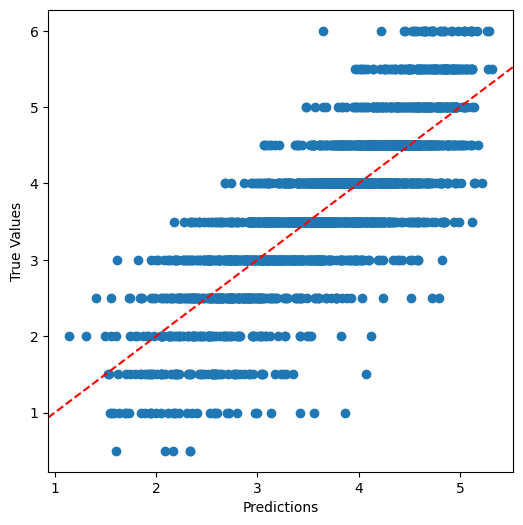

In [48]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_scores_df['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([216., 843., 760., 399., 162.,  62.,  14.,  10.,   3.,   2.]),
 array([0.00452803, 0.02276749, 0.04100695, 0.05924641, 0.07748587,
        0.09572532, 0.11396478, 0.13220423, 0.15044369, 0.16868316,
        0.18692261]),
 <BarContainer object of 10 artists>)

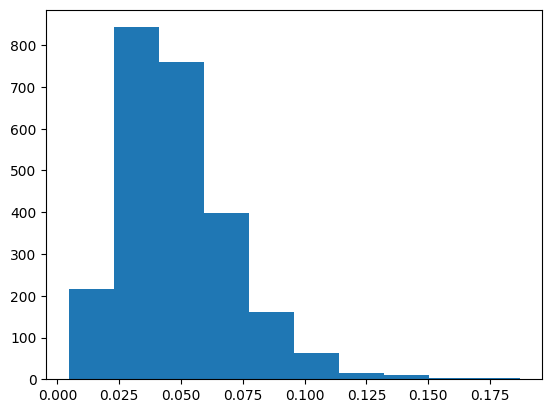

In [49]:
plt.hist(stds)

In [ ]:
valid_predict[0]

In [ ]:
X_valid